In [1]:
import modules
import torchvision.transforms as T
import torch
import ast

dict_keys(['multiprocessing', 'path_pretrained_models', 'execute_code', 'dataset', 'gpt', 'llava', 'answerer', 'planner', 'retriever', 'extractor', 'evaluator', 'save', 'save_new_results', 'results_dir', 'use_cache', 'clear_cache', 'use_cached_codex', 'cached_codex_path', 'log_every', 'wandb', 'blip_half_precision', 'blip_v2_model_type', 'use_fixed_code', 'fixed_code_file'])
./prompts/base_prompt.txt


In [2]:
# blip = modules.BLIPModel(gpu_number=0, half_precision=True)
# siglip = modules.SiglipModel(gpu_number=1)
llava = modules.LLAVA(gpu_number=0)
siglip = modules.SiglipModel(gpu_number=3)
gpt = modules.GPTModel(gpu_number=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [128]:
class Localizer():
    def __init__(self, siglip_model, caption_model):
        self.siglip_model = siglip_model
        self.caption_model = caption_model
        
    def get_relevant_frame(self, video, statement: list):
        frame_numbers, frames = self.siglip_model.forward(video, statement)
        frame_numbers = frame_numbers.detach().cpu().item()
        print(frame_numbers)
        return frame_numbers
    
    def query_caption(self, frame_number: int, video_info):
        # transform = T.ToPILImage()
        # frame = [transform(video_info[frame_number])]
        frame = [video_info[frame_number]]
        # caption = self.caption_model.caption(image=frame)
        caption = self.caption_model.forward(image_list=frame, question="Describe this image in detail.")
        caption = caption.replace('\n\n', ' ')
        return caption
    
    def load_video_info(self, video_info, statement: str): 
        # TODO: need to enfource proper tyipng for statement
        relevant_frame = self.get_relevant_frame(video_info.images, [statement])
        start = 0
        end = video_info.length - 1
        
        video_info.caption_memory[start] = self.query_caption(start, video_info)
        video_info.caption_memory[relevant_frame] = statement
        video_info.caption_memory[end] = self.query_caption(end, video_info)
            # video_info.vqa_memory[i] = self.caption_model.query_VQA(frame_number=i, question=subquestion, video_info=video_info)

In [120]:
class Answerer():
    def __init__(self, caption_model, vqa_model, llm):
        self.caption_model = caption_model
        self.vqa_model = vqa_model
        self.llm = llm

    # @staticmethod
    def construct_prompt(self, question, choices, video_info):
        with open('prompts/base_prompt.txt', 'r') as f:
            prompt = f.read()
        prompt = prompt.replace('insert_question', question)
        prompt = prompt.replace('insert_choices', str(choices))
        
        summary = ''
        for frame_number in sorted(video_info.caption_memory):
            summary += f'- Frame {frame_number}: {video_info.caption_memory[frame_number]}\n'
            # if frame_number in video_info.vqa_memory:
            #     summary += f', {video_info.vqa_memory[frame_number]}'
            if frame_number in video_info.vqa_memory:
                summary += f'- Frame {frame_number}: {video_info.vqa_memory[frame_number]}\n'
        prompt = prompt.replace('insert_summary', summary)
        return prompt
    

    def query_caption(self, frame_number: int, video_info):
        # transform = T.ToPILImage()
        # frame = [transform(video_info[frame_number])]
        frame = [video_info[frame_number]]
        # caption = self.caption_model.caption(image=frame)
        caption = self.caption_model.forward(image_list=frame, question="Describe this image in detail.")
        return caption

    def query_VQA(self, question: str, frame_number: int, video_info):
        # frame = video_info[frame_number].unsqueeze(0)
        frame = [video_info[frame_number]]
        # transform = T.ToPILImage()
        # frame = [transform(video_info[frame_number])]
        # answer = self.vqa_model.qa(image=frame, question=question)
        answer = self.vqa_model.forward(image_list=frame, question=question)
        return answer

    def select_frame():
        pass

    def get_answer(self, question, subquestion, choices, video_info, LIMIT=10):
        """Main functionality for retrieving an answer to a question."""
        
        # load beg, relevant frame, end in video_info
        
        while LIMIT > 0:
            print(f'Iteration: {10 - LIMIT}')
            LIMIT -= 1
            prompt = self.construct_prompt(question, choices, video_info)
            print(prompt)
            response = self.llm.call_llm(prompt)
            print(response)
            parts = response.split('<explanation>')
            explanation = parts[0]
            command = parts[1].strip()
            args = ast.literal_eval(command)
            
            label = args[0]
            number = args[1]
            
            video_info.explanations.append(explanation)
            if label == 'done':
                # number is index of answer choice
                return number
            elif label == 'before':
                # need to add in logic that will look thru dictionary for the right split x + y / 2
                if number == 0:
                    continue
                frame_numbers = sorted(video_info.caption_memory.keys())
                for i, curr_frame_number in enumerate(frame_numbers):
                    if curr_frame_number == number:
                        prev_frame_number = frame_numbers[i - 1]
                        break
                new_frame_number = int((prev_frame_number + curr_frame_number) / 2)
            elif label == 'after':
                # need to add in logic that will look thru dictionary for the right split x + y / 2
                if number == video_info.length - 1:
                    continue
                frame_numbers = sorted(video_info.caption_memory.keys())
                for i, curr_frame_number in enumerate(frame_numbers):
                    if curr_frame_number == number:
                        next_frame_number = frame_numbers[i + 1]
                        break
                new_frame_number = int((curr_frame_number + next_frame_number) / 2)
            
            caption = self.query_caption(new_frame_number, video_info)
            caption = caption.replace('\n\n', ' ')
            video_info.caption_memory[new_frame_number] = caption
            
            # TODO: remove subquestion out of here?
            vqa_answer = self.query_VQA(subquestion, new_frame_number, video_info)
            vqa_answer = vqa_answer.replace('\n\n', ' ')
            video_info.vqa_memory[new_frame_number] = vqa_answer
        return


In [130]:
localizer = Localizer(siglip_model=siglip, caption_model=llava)

In [121]:
answerer = Answerer(caption_model=llava, vqa_model=llava, llm=gpt)

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_frame_numbers(frame_numbers):
    plt.scatter(frame_numbers, np.zeros(len(frame_numbers)))

In [7]:
from vidutils import VideoInfo
from utils import get_video

  deprecate(



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
cuda cuda


In [8]:
video_id = 4825249972
question = "what did the brown dog do before it started chasing the cat"
options = ['climbing over it', 'lying down', 'jump on the sofa and bark', 'sit and watch', 'walk back']
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

In [64]:
transform = T.ToPILImage()
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]
video_info = VideoInfo(images=images)
video_info.length

93

In [65]:
localizer.load_video_info(video_info, 'brown dog started chasing the cat')

62


In [66]:
video_info.caption_memory

{0: 'The image features a person sitting in a room, with a dog close to them. The dog is positioned on the left side of the person, and the person is seated on a chair. The room also contains a dining table, which is located towards the right side of the scene.There are two books in the room, one placed on the dining table and the other on the floor near the person. Additionally, a remote control can be seen resting on the dining table. The overall atmosphere of the scene suggests a cozy and comfortable setting where the person and their dog are enjoying some leisure time.',
 62: 'The image features a dog standing in the middle of a cluttered room, possibly a living room or a playroom. The dog is looking at the camera, and it appears to be in the center of attention. The room is filled with various items, including several books scattered around the floor, a couch in the background, and a chair nearby.There are also a couple of bowls placed on the floor, one closer to the dog and the o

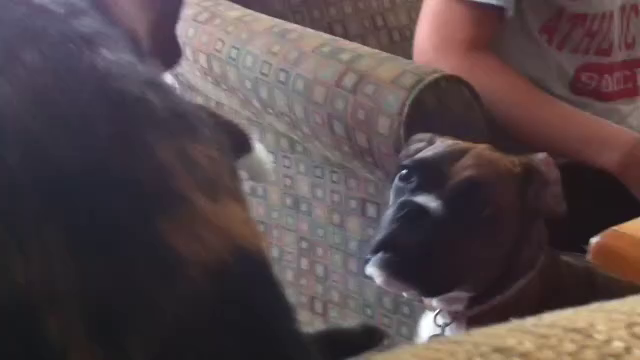

In [24]:
image = video_info[27]
image

In [56]:
subquestion = 'what did the brown dog do'

In [67]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a question based on captions of events that occurred. You will choose the correct answer choice if there is enough information. Otherwise, you will choose an existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information, followed by the token <explanation> to end the explanation.  Keep explanations concise and to the point. Then, in a tuple, either state 'done' followed by the index of the answer choice, 'before' and the existing frame number to look before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can only look before it.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating

In [68]:
video_info.vqa_memory

{31: 'The brown dog is sitting on a couch, looking at the camera.',
 15: 'The brown dog is sitting at a table, looking at a cell phone.',
 23: 'The brown dog is sitting on the couch next to a person.',
 46: 'The brown dog is standing on a chair, looking at the camera.',
 27: 'The brown dog is sitting on a couch, looking at a black dog.',
 25: 'The brown dog is sitting on the floor, looking up at the person who is sitting on the couch.',
 38: 'The brown dog is standing on its hind legs, possibly trying to get a better view or interact with the person in the image.',
 24: 'The brown dog is sitting on a couch, looking at the camera.'}

In [69]:
video_info.caption_memory

{0: 'The image features a person sitting in a room, with a dog close to them. The dog is positioned on the left side of the person, and the person is seated on a chair. The room also contains a dining table, which is located towards the right side of the scene.There are two books in the room, one placed on the dining table and the other on the floor near the person. Additionally, a remote control can be seen resting on the dining table. The overall atmosphere of the scene suggests a cozy and comfortable setting where the person and their dog are enjoying some leisure time.',
 62: 'The image features a dog standing in the middle of a cluttered room, possibly a living room or a playroom. The dog is looking at the camera, and it appears to be in the center of attention. The room is filled with various items, including several books scattered around the floor, a couch in the background, and a chair nearby.There are also a couple of bowls placed on the floor, one closer to the dog and the o

In [70]:
video_info.explanations

['There is not enough information to determine what the brown dog did before chasing the cat. The captions provided do not mention any actions or behaviors of the dog before the chasing event. We need to look before frame 62 to gather more context.\n',
 'Based on the given captions, there is no information about what the brown dog was doing before it started chasing the cat. We need to look before frame 31 to find more context. ',
 'Based on the provided captions, there is not enough information to determine what the brown dog did before it started chasing the cat. The captions do not mention any actions of the dog before it started chasing the cat. We need to look before frame 31.\n',
 'Based on the information provided, there is not enough information to determine what the brown dog did before it started chasing the cat. None of the given frames mention any specific action performed by the dog before chasing the cat. We need to look before frame 62 to gather more information. \n',
 '

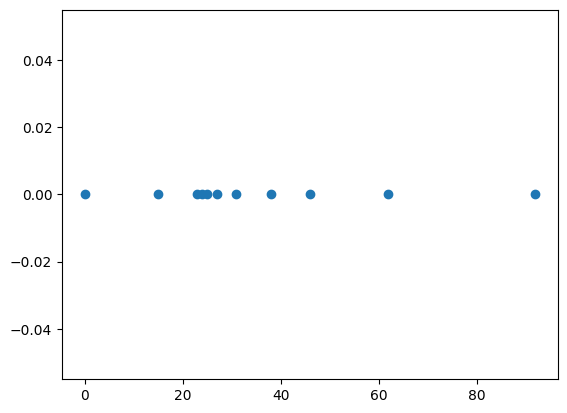

In [72]:
plot_frame_numbers(video_info.caption_memory.keys())

In [73]:
video_id = 7499375636
question = "what did the man in black at the back do before the man with black and green helmet drove away?"
options = ['looking at them', 'step back', 'adjusting helmet', 'driving off', 'raise his hand out the window']
# correct answer: 1
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

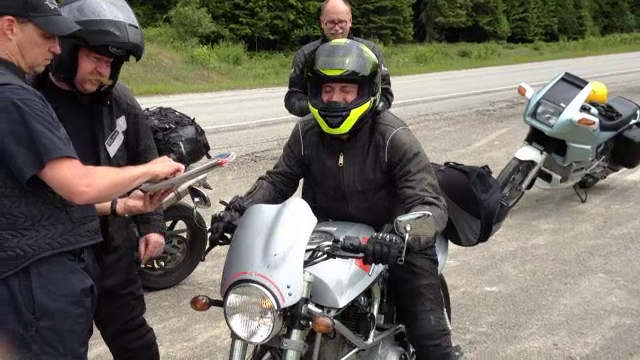

In [74]:
transform = T.ToPILImage()
image = transform(video[58])
image

In [75]:
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]
video_info = VideoInfo(images=images)

subquestion = 'what did the man in black at the back do'

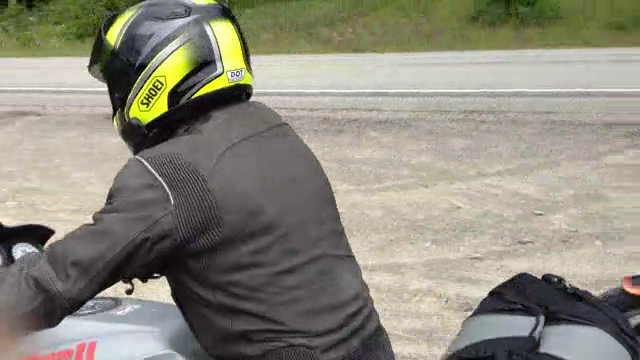

In [78]:
video_info[56]

In [76]:
localizer.load_video_info(video_info, 'the man with black and green helmet drove away')

56


In [77]:
video_info.caption_memory

{0: 'The image features a group of people gathered around a silver motorcycle, with one man sitting on the motorcycle and another man standing beside him. The group consists of at least five people, with some standing closer to the motorcycle and others further away.In addition to the motorcycle, there are two backpacks visible in the scene, one located near the center and the other towards the right side. The presence of backpacks suggests that the group might be on a trip or an adventure.',
 56: 'The image features a man sitting on a motorcycle, wearing a helmet and a grey jacket. He appears to be taking a break or preparing to ride. The motorcycle is parked on a dirt road, and the man is sitting on the ground next to it.In the scene, there are also two backpacks, one located near the man on the motorcycle and the other further away. A handbag can be seen placed on the ground, closer to the man. The overall atmosphere suggests an outdoor adventure or a trip on the motorcycle.',
 160:

In [79]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a question based on captions of events that occurred. You will choose the correct answer choice if there is enough information. Otherwise, you will choose an existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information, followed by the token <explanation> to end the explanation.  Keep explanations concise and to the point. Then, in a tuple, either state 'done' followed by the index of the answer choice, 'before' and the existing frame number to look before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can only look before it.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating

0

In [80]:
video_info.explanations

['There is not enough information to determine what the man in black at the back did before the man with the black and green helmet drove away. The description only mentions their presence and does not provide any details about their actions. We need to look before frame 56 to gather more information.\n',
 'There is not enough information to determine what the man in black at the back did before the man with black and green helmet drove away. While we have information about the actions of the man with the helmet (sitting on the motorcycle), we do not have any information about the actions of the man in black at the back. We need to look before frame 56 for more context.\n',
 'The caption does not provide any information about the actions of the man in black at the back before the man with the black and green helmet drove away. We need to look before frame 56 to gather more information.\n',
 'There is enough information to determine what the man in black at the back did before the man w

In [81]:
video_info.caption_memory

{0: 'The image features a group of people gathered around a silver motorcycle, with one man sitting on the motorcycle and another man standing beside him. The group consists of at least five people, with some standing closer to the motorcycle and others further away.In addition to the motorcycle, there are two backpacks visible in the scene, one located near the center and the other towards the right side. The presence of backpacks suggests that the group might be on a trip or an adventure.',
 56: 'The image features a man sitting on a motorcycle, wearing a helmet and a grey jacket. He appears to be taking a break or preparing to ride. The motorcycle is parked on a dirt road, and the man is sitting on the ground next to it.In the scene, there are also two backpacks, one located near the man on the motorcycle and the other further away. A handbag can be seen placed on the ground, closer to the man. The overall atmosphere suggests an outdoor adventure or a trip on the motorcycle.',
 160:

In [82]:
video_info.vqa_memory

{28: 'The man in black at the back is holding a clipboard, which suggests that he might be a police officer or a traffic enforcement officer. He is standing behind the group of men with motorcycles, possibly observing or monitoring the situation.',
 42: 'The man in black at the back is a police officer, and he is writing a ticket for the motorcyclist.',
 49: 'The man in black at the back is a police officer. He is standing behind the man on the motorcycle, possibly observing or monitoring the situation.'}

In [92]:
video_id = 4144360777
question = "what did the girl in striped do before going up the sofa?"
options = ['pet', 'walking around the table', 'lie on her stomach', 'playing with sofa', 'hold another toy']
# correct answer: 1
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

In [96]:
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]
video_info = VideoInfo(images=images)

subquestion = 'what did the girl in striped do'

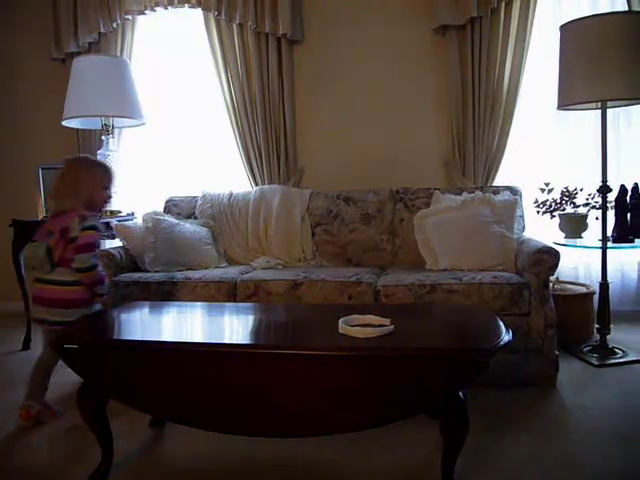

In [97]:
video_info.images[7]

In [98]:
localizer.load_video_info(video_info, 'girl going up the sofa')

7


In [99]:
video_info.caption_memory

{0: 'The image features a young girl standing in a living room, holding a Wii remote and playing a video game. She is standing in front of a couch, which is positioned against the wall. The living room is furnished with a chair located near the couch, and a dining table can be seen in the background.There are several books scattered around the room, with some placed on the floor and others on the dining table. A bottle is also visible in the scene, placed near the edge of the room. The girl appears to be enjoying her time playing the video game, immersed in the gaming experience.',
 7: 'The image features a young girl playing with a remote control in a living room. She is standing in front of a couch, which is positioned against the wall. The couch has a floral pattern and is accompanied by a chair nearby. There are two potted plants in the room, one located on the left side and the other on the right side. A vase can be seen on the right side of the room, and a clock is mounted on the

In [100]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a question based on captions of events that occurred. You will choose the correct answer choice if there is enough information. Otherwise, you will choose an existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information, followed by the token <explanation> to end the explanation.  Keep explanations concise and to the point. Then, in a tuple, either state 'done' followed by the index of the answer choice, 'before' and the existing frame number to look before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can only look before it.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating

3

In [101]:
video_info.caption_memory

{0: 'The image features a young girl standing in a living room, holding a Wii remote and playing a video game. She is standing in front of a couch, which is positioned against the wall. The living room is furnished with a chair located near the couch, and a dining table can be seen in the background.There are several books scattered around the room, with some placed on the floor and others on the dining table. A bottle is also visible in the scene, placed near the edge of the room. The girl appears to be enjoying her time playing the video game, immersed in the gaming experience.',
 7: 'The image features a young girl playing with a remote control in a living room. She is standing in front of a couch, which is positioned against the wall. The couch has a floral pattern and is accompanied by a chair nearby. There are two potted plants in the room, one located on the left side and the other on the right side. A vase can be seen on the right side of the room, and a clock is mounted on the

In [102]:
video_info.vqa_memory

{35: 'The girl in striped pants is sitting on the floor, playing with a toy, and smiling.',
 21: 'The girl in the striped hoodie is playing with a dog in the living room.',
 28: 'The girl in striped clothing is playing in the living room, standing on a couch and looking at the camera.',
 31: 'The girl in striped pajamas is sitting on the floor, playing with a dog.'}

In [103]:
video_info.explanations

['There is no information about what the girl in striped did before going up the sofa. All the frames provided describe the girl playing with a remote control in the living room. We need to look before frame 0 to gather more information.\n',
 'The captions do not provide enough information about what the girl in striped pants did before going up the sofa. None of the frames mention any specific actions that the girl took before going up the sofa. We need to look before frame 35 to gather more information.\n',
 'Based on the captions, we know that the girl in striped pants was playing with a toy and smiling before going up the sofa. However, we do not have enough context to know what exactly the girl was doing among the answer choices. We need to look before frame 35.\n',
 'There is not enough information to determine what the girl in striped did before going up the sofa. The captions provide information about the girl playing with a dog, sitting on the floor with a toy, and smiling, bu

In [104]:
video_id = 2797596111
question = "what did the boy in black do before he started singing at the beginning of the video?"
options = ['drink from it', 'pick little boy up', 'plays the guitar', 'looking at toy on ground', 'throw it at dog']
# correct answer: 1
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

In [105]:
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]
video_info = VideoInfo(images=images)

subquestion = 'what did the boy in black do'

In [106]:
localizer.load_video_info(video_info, 'the boy started singing')

64


In [107]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a question based on captions of events that occurred. You will choose the correct answer choice if there is enough information. Otherwise, you will choose an existing frame to look before or after. Think step by step.

Give an explanation for why there is or there is not enough information, followed by the token <explanation> to end the explanation.  Keep explanations concise and to the point. Then, in a tuple, either state 'done' followed by the index of the answer choice, 'before' and the existing frame number to look before, or 'after' and the existing frame to look after.

For frame 0, you can only look after it. For the last frame number, you can only look before it.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating

2

In [108]:
video_info.caption_memory

{0: 'The image features a group of four young men playing music together on stage. They are all dressed in black and are standing in front of a drum set. Two of the men are playing guitars, while the other two are playing drums. The stage is set up with a few microphones, and a keyboard can be seen in the background.There are two chairs placed on the stage, one near the left side and the other near the right side. The overall atmosphere of the scene suggests that the band is performing in a concert or a similar event.',
 64: 'The image features a young man singing into a microphone, with a guitar in his hand. He is accompanied by two other people, one on the left side and another on the right side of the scene. The guitarist is standing behind the singer, while the other person is positioned slightly to the right of the guitarist.There are two guitars in the scene, one held by the singing man and another one placed on the right side of the image. Additionally, there is a drum set in th

In [109]:
video_info.vqa_memory

{32: 'The boy in black is playing the drums while the other boys are playing their instruments.',
 134: 'The boy in black is playing a guitar, specifically a black electric guitar, while standing in front of a microphone. He is likely performing or practicing his guitar skills, possibly in a band or as a solo musician.',
 48: 'The boy in black is singing into a microphone while standing in front of a drum set.',
 40: 'The boy in black is playing the drums during the concert.',
 16: 'The boy in black is playing the drums during the performance.',
 8: 'The boy in black is playing the drums, standing next to the other members of the band.'}

In [110]:
video_info.explanations

['The caption does not provide any information about what the boy in black did before he started singing. We do not have enough information to choose an answer choice. We need to look before frame 64.\n',
 'Based on the captions, we know that the boy in black started singing at the beginning of the video. However, we do not have enough information to determine what the boy in black did before he started singing among the answer choices. We need to look before frame 0.\n',
 'The description of the frames does not provide any information about what the boy in black did before he started singing. We do not have enough context to know what the boy was doing among the answer choices. We need to look before frame 64.\n',
 'The prompt provides several frames that occur before and after the specific event mentioned in the question stem. It is clear from the summary that the boy in black starts singing at the beginning of the video. However, there is not enough information given in the captions

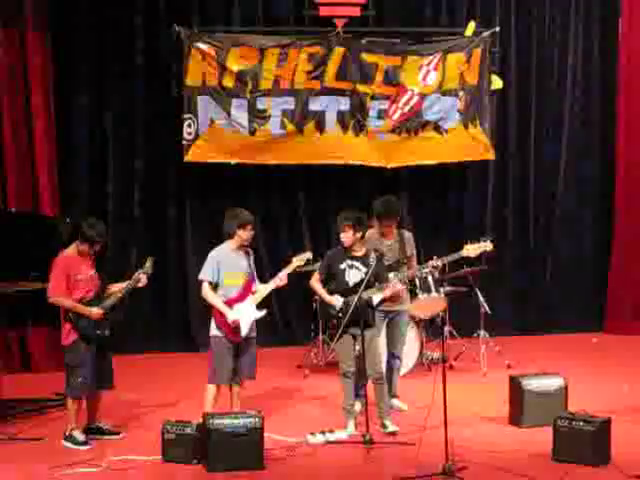

In [111]:
video_info[134]

In [136]:
video_id = 11162473963
question = "what did the boy do before the girl popped up from the leaves"
options = ['opens it again', 'whisper', 'tries to find girl and fell', 'eat', 'looking at toy on ground']
# correct answer: 2
video = get_video(f'/shared/shang/datasets/nextqa/videos/{video_id}.mp4')

In [141]:
images = [transform(video[i]) for i in range(0, video.shape[0], 10)]
video_info = VideoInfo(images=images)

subquestion = 'what did the boy do'

In [142]:
localizer.load_video_info(video_info, 'the girl popped up from the leaves')

125


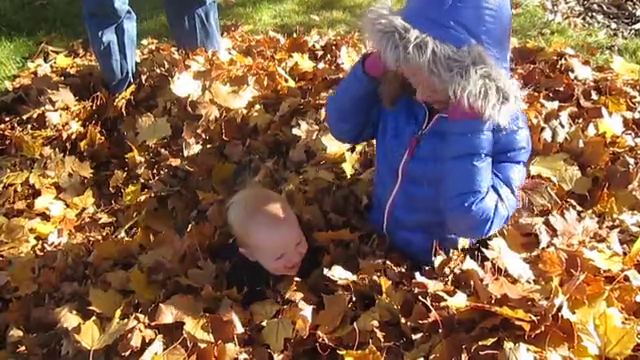

In [116]:
video_info[125]

In [143]:
answerer.get_answer(question=question, subquestion=subquestion, choices=options, video_info=video_info)

Iteration: 0
You are a machine that answers a question about videos. You will answer a question based on captions of events that occurred. You will choose the correct answer choice if there is enough information. Otherwise, you will choose an existing frame to look before or after. You must choose an answer among the choices. Think step by step.

Give an explanation for why there is or there is not enough information, followed by the token <explanation> to end the explanation.  Keep explanations concise and to the point. Then, in a tuple, either state 'done' followed by the index of the answer choice, 'before' and the existing frame number to look before, or 'after' and the existing frame to look after.

('before', 0) is not allowed.


### Examples ###
Question: what did the girl do before eating the ice cream
Choices: ['read a book', 'watch television', 'wipe her hands', 'lie down', 'sleep']

Summary:
- Frame 0: a girl in the living room
- Frame 10: a girl eating ice cream
- Frame 25:

In [154]:
answerer.caption_model.forward([video_info[115]], 'did the boy fall')

'Yes, the boy appears to have fallen into the pile of leaves, as he is surrounded by them.'

In [144]:
video_info.explanations

["There is not enough information to determine what the boy did before the girl popped up from the leaves. The given captions do not provide any context or clues about the boy's actions. We need to look after frame 125 to gather more information.\n",
 'The caption indicates that the girl popped up from the leaves. However, there is not enough information to determine what the boy was doing before the girl popped up. The provided frames do not mention or show any specific action or activity that the boy was doing before the girl popped up. We need to look before frame 128 to gather more information.\n',
 'There is not enough information to determine what the boy did before the girl popped up from the leaves. The captions only describe the girl popping up from the leaves and the boy playing in the leaves. We need to look before frame 125 to gather more information.\n',
 'We have enough information to know that the boy was playing in the leaves before the girl popped up. However, we do no

In [145]:
video_info.caption_memory

{0: 'The image captures a person standing in a pile of leaves, possibly raking them up. The person is positioned in the center of the scene, with their legs visible as they work on the task. The leaves are spread all around the person, creating a colorful and vibrant scene. The leaves vary in size and are scattered across the ground, creating a visually appealing and natural environment.',
 125: 'The image features a little girl and a baby sitting in a pile of leaves, likely enjoying the autumn season. The little girl is wearing a blue jacket, while the baby is wearing a black shirt. They are surrounded by a variety of leaves, creating a cozy and colorful environment. In the background, there are three other people, possibly adults or other children, who are not directly involved in the scene. The presence of these individuals suggests that the scene may be taking place in a park or a public area where people are enjoying the fall season.',
 132: 'The image shows a young child playing 

In [146]:
video_info.vqa_memory

{128: 'The boy is playing in the leaves, specifically in a pile of leaves.',
 126: 'The boy is playing in the leaves, specifically in a pile of leaves, and he is laughing while doing so.',
 62: 'The boy is pointing at something on the ground, possibly a leaf or an object, while standing in a pile of leaves.',
 93: 'The boy is playing in a pile of leaves, which are scattered on the ground. He is standing in the middle of the pile of leaves, enjoying his time and exploring the area.',
 109: 'The boy is playing in a pile of leaves, likely enjoying the experience of being surrounded by the colorful leaves.',
 117: 'The boy is playing in a pile of leaves, possibly in a yard or a park. He is wearing a blue jacket and is surrounded by leaves, which suggests that he is enjoying the autumn season and engaging in a fun outdoor activity.',
 125: 'The boy is sitting in a pile of leaves, playing and having fun.',
 127: 'The boy is playing in a pile of leaves, smiling and enjoying himself.'}

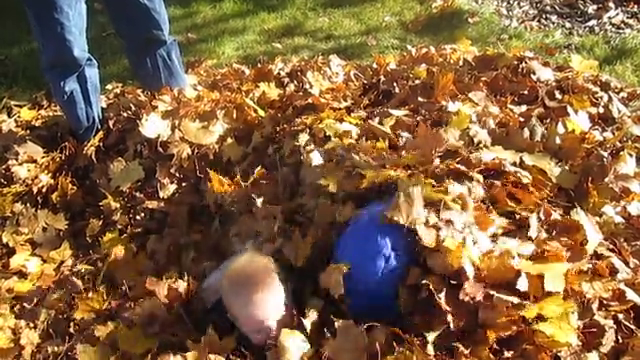

In [152]:
video_info[115]